# prefectを使ってみよう

## ローカル実行

まず最初にローカルで実行してみます。<br>
スクリプトでも良いのですが、nbでも使えるので下記のcellを順次実行してみます。<br>
これは運行中の飛行機のデータを抽出し、加工、保存するETL処理のスクリプト例です。<br>
nbではなくスクリプトを実行する例を見たい場合は、`example/prefect_tutorials`にあるスクリプトを<br>
`$pyhon hoge.py`で実行してみてください。

prefectではジョブの最小単位をタスクとよび、タスクをつなぎ合わせたものをflowと言います。<br>

In [1]:
from prefect import task, Flow

import sys,os
sys.path.append('/home/work/example/prefect_tutorials')
import aircraftlib as aclib

関数に`@task`をデコレートするだけでタスクとして扱われます。<br>
他にも多くのタスクメソッドが標準で存在しており、例えばwebhookによる通知(slack通知に使える)<br>
S3に対するダウンロードやアップロード,Databricksに対するサブミット、githubに対するPRの発行<br>
notebookの実行、等々色々なものが定義されています。<br>
詳しくはこちらのリファレンスでhttps://docs.prefect.io/api/latest/

In [2]:
@task
def extract_reference_data():
    print("fetching reference data...")
    return aclib.fetch_reference_data()


@task
def extract_live_data():
    # Get the live aircraft vector data around Dulles airport
    dulles_airport_position = aclib.Position(lat=38.9519444444, long=-77.4480555556)
    area_surrounding_dulles = aclib.bounding_box(dulles_airport_position, radius_km=200)

    print("fetching live aircraft data...")
    raw_aircraft_data = aclib.fetch_live_aircraft_data(area=area_surrounding_dulles)

    return raw_aircraft_data


@task
def transform(raw_aircraft_data, ref_data):
    print("cleaning & transform aircraft data...")

    live_aircraft_data = []
    for raw_vector in raw_aircraft_data:
        vector = aclib.clean_vector(raw_vector)
        if vector:
            aclib.add_airline_info(vector, ref_data.airlines)
            live_aircraft_data.append(vector)

    return live_aircraft_data


@task
def load_reference_data(ref_data):
    print("saving reference data...")
    db = aclib.Database()
    db.update_reference_data(ref_data)


@task
def load_live_data(live_aircraft_data):
    print("saving live aircraft data...")
    db = aclib.Database()
    db.add_live_aircraft_data(live_aircraft_data)


定義したタスクたちをflowとしてつなぎ合わせます。<br>
返り値をそのまま次のタスクの引数として渡せるので、とても自然にflowが記述できます<br>
他にも、並列実行のためのmapや、前述の実行終了まで待ってから実行するdownstream_tasksなどもあります。<br>
詳しくはこちらのリファレンスでhttps://docs.prefect.io/api/latest/

In [3]:
with Flow("etl") as flow:
    reference_data = extract_reference_data()
    live_data = extract_live_data()

    transformed_live_data = transform(live_data, reference_data)

    load_reference_data(reference_data)
    load_live_data(transformed_live_data)

flow.run()

[2021-07-05 21:12:47+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'etl'
[2021-07-05 21:12:47+0900] INFO - prefect.TaskRunner | Task 'extract_reference_data': Starting task run...
fetching reference data...
[2021-07-05 21:12:48+0900] INFO - prefect.TaskRunner | Task 'extract_reference_data': Finished task run for task with final state: 'Success'
[2021-07-05 21:12:48+0900] INFO - prefect.TaskRunner | Task 'extract_live_data': Starting task run...
fetching live aircraft data...
[2021-07-05 21:12:48+0900] INFO - prefect.TaskRunner | Task 'extract_live_data': Finished task run for task with final state: 'Success'
[2021-07-05 21:12:48+0900] INFO - prefect.TaskRunner | Task 'load_reference_data': Starting task run...
saving reference data...
[2021-07-05 21:12:54+0900] INFO - prefect.TaskRunner | Task 'load_reference_data': Finished task run for task with final state: 'Success'
[2021-07-05 21:12:55+0900] INFO - prefect.TaskRunner | Task 'transform': Starting task run...
cleaning & 

<Success: "All reference tasks succeeded.">

簡易なビジュアライズも簡単

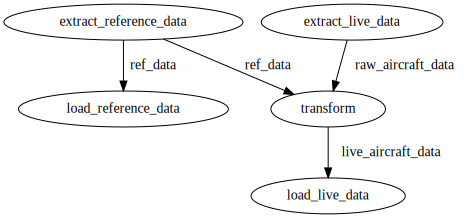

In [4]:
flow.visualize()

## サーバーに登録して実行

ではサーバーにflowを登録してみます。<br>
登録にはCLIとメソッドによる登録が存在します。<br>
CLIの場合は<br>
`prefect register -p hoge.py --project "fuga Project"`<br>
で登録できます。<br>

メソッドの場合はスクリプト内で`flow.register()`を記述し、下記を実行する事で登録できます。<br>
`$python hoge.py`<br>

今回は、random_errorという1/2の確率でタスクが失敗するタスクを8個並べたflowをクラスメソッドで登録してみます。

In [5]:
!python random_error/random_error.py

[2021-07-05 21:12:57+0900] INFO - prefect.S3 | Uploading random-errors/2021-07-05t12-12-57-021273-00-00 to prefect
Flow URL: http://localhost:8080/default/flow/b53a7e24-bd46-4b1a-a103-1f2ef342d3c8
 └── ID: 8de08287-1cb7-4214-9b0f-f3b0406759ad
 └── Project: My Project
 └── Labels: ['dev']


In [6]:
!python prefect_tutorials/06_parallel_execution.py

[2021-07-05 21:13:00+0900] INFO - prefect.S3 | Uploading etl/2021-07-05t12-13-00-599207-00-00 to prefect
Flow URL: http://localhost:8080/default/flow/0c81824d-e1c7-4f15-8f94-8220c3d11668
 └── ID: 303d45c3-3f98-4874-8ad9-4e096724c603
 └── Project: My Project
 └── Labels: ['dev']


Jupyter Lab<br>
http://localhost:8819<br>
Mlflow<br>
http://localhost:5050<br>
Prefect UI<br>
http://localhost:8080<br>
Minio<br>
http://localhost:9000<br>